In [1]:
import shelve
import gdbm
mod = __import__('gdbm')
import dumbdbm
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import datasets, decomposition
import numpy as np
import gc
from datetime import datetime
import datetime as dt
#datetime.strptime('2016-03-29','%Y-%d-%m')
import dateparser
from ipykernel import kernelapp as app
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from operator import itemgetter
import folium
from folium.plugins import HeatMap
import Instalib as IL
import math
import re
import string
import emoji
import pickle
import scipy.io
from sklearn.feature_extraction.text import CountVectorizer
import nltk.stem
import sktensor
import geopy.distance
from itertools import groupby
import ncp
from datetime import timedelta
from dateutil.relativedelta import *
import os

# Open the file and have a first look

Read the data and concatenate in a single DataFrame file, basic file format for pandas. It's a 2-D object, tabular file with labeled rows and columns, built from a dictionary or such. 

More info about it here: https://pandas.pydata.org/pandas-docs/stable/10min.html

Make our life easier by matching the Torino labels with the Marseille ones and convert strings to datetime

In [178]:
df_new=pd.read_csv('/data/marcoq/instagram/torino/torino_posts.csv',lineterminator='\n')
df_new=df_new.rename(columns = {'caption':'text','taken_at_timestamp':'date'})
df_new.head()

,date,text,location_id
0,2017-11-14 16:20:42,After great week to home of my Friend this sac...,135250610358325
1,2017-10-31 16:10:00,Fisrt Flower of my new style.. thanx Teresa.. ...,135250610358325
2,2017-10-16 15:22:37,This for new roses!! Thanx Simone!!#walterbian...,135250610358325
3,2017-10-05 15:40:03,New skull !! #walterbianco_wb #wbtattooartgall...,135250610358325
4,2017-10-03 16:13:43,Paint acrilic biomech on sale 40cm X 30 cm o...,135250610358325


In [173]:
list_dates, Histo = IL.N_posts(df_new, debug=False)
Npostslog=[np.log10(H) for H in Histo]
Nposts=[H for H in Histo]

In [ ]:
if 'Figures' not in os.listdir('.') and False:
    os.mkdir('Figures')
    os.mkdir('Figures/Shape')
    os.mkdir('Figures/Shape/Spatial')
    os.mkdir('Figures/Shape/Temporal')
plt.figure()
plt.scatter(list_dates, Npostslog)
plt.xticks(list_dates[0::15])
plt.ylabel(r'$log_{10}$(#posts)')
plt.xlabel('Timeline')
plt.title(r'$log_{10}$ of the amount of insta posts per months')
#plt.savefig('Figures/Shape/Temporal/Torino_logN.pdf')
plt.show()
plt.figure()
plt.scatter(list_dates, Nposts)
plt.xticks(list_dates[0::15])
plt.ylabel('#posts)')
plt.xlabel('Timeline')
plt.title('Absolute amount of insta posts per months')
#plt.savefig('Figures/Shape/Temporal/Torino_N.pdf')
plt.show()

In [174]:
df_location_all=pd.read_csv('/data/marcoq/instagram/torino/torino_locations.csv', lineterminator='\n')
df_location_all=df_location_all.rename(columns = {'latitude':'lat','longitude':'lon', 'location_id':'id'})
df_location_all.head()

,id,name,lat,lon
0,135250610358325,WB Tattoos Art Gallery,45.072270,7.693010
1,346586842349479,InQubatore Qulturale,45.133572,7.631137
2,328277161003275,Mixed By Luca Pain,45.081999,7.661826
3,1022295605,06565,45.063780,7.681740
4,127109984575725,Café Müller,45.061100,7.676030


In [175]:
#remember zip:
zip([1,2,3],['a','b','c'])
#it's a function.
#make a new column 'coord' indexing (lat,lon) for each post
df_location_all['coord'] = list(zip(df_location_all.lat,df_location_all.lon))
df_location_all.head()

,id,name,lat,lon,coord
0,135250610358325,WB Tattoos Art Gallery,45.072270,7.693010,"(45.07227, 7.69301)"
1,346586842349479,InQubatore Qulturale,45.133572,7.631137,"(45.1335721884, 7.631136775)"
2,328277161003275,Mixed By Luca Pain,45.081999,7.661826,"(45.081999413, 7.6618255282)"
3,1022295605,06565,45.063780,7.681740,"(45.06378, 7.68174)"
4,127109984575725,Café Müller,45.061100,7.676030,"(45.0611, 7.67603)"


In [16]:
#Heatmap per year
TbyCoord=IL.time_coord(df_location_all, df_new)
for year in range(2010,2019,1):
    Coordinates=[]
    for t in TbyCoord:
        if t[0][0:4]==str(year):
            Coordinates.append(t[1])
    IL.geo_heatmap(Coordinates ,Nposts, save=False,filename='hm'+str(year))

# Let's refine the DataFrame

In [17]:
#link postID with its location
dict_id_coord= dict(zip(df_location_all.id,df_location_all.coord))
dict_id_name= dict(zip(df_location_all.id,df_location_all.name))
dict_coord_name= dict(zip(df_location_all.coord,df_location_all.name))

series.map() matches corresponding entries from two different series files. This is what x.map(y) does:

In [18]:
x = pd.Series([1,2,3], index=['one', 'two', 'three'])
x

one      1
two      2
three    3
dtype: int64

In [19]:
y = pd.Series(['foo', 'bar', 'baz'], index=[1,2,3])
y

1    foo
2    bar
3    baz
dtype: object

In [20]:
x.map(y)

one      foo
two      bar
three    baz
dtype: object

In [24]:
z = pd.Series(['foo', 'bar', 'baz'], index=[3,1,2])
z

3    foo
1    bar
2    baz
dtype: object

In [25]:
x.map(z)

one      bar
two      baz
three    foo
dtype: object

In [179]:
#Adding a column 'coords' by mapping the coordinates to their location_id:
df_new['coords'] = df_new['location_id'].map(dict_id_coord)
# And a column 'name' by mapping the location ids to their associate name.
df_new['name'] = df_new['location_id'].map(dict_id_name)

#Create lat and lon columns by reading coords
# Look here: https://pythonhow.com/accessing-dataframe-columns-rows-and-cells/
df_new['lat']=[e[0] for e in df_new.loc[:,'coords']]
df_new['lon']=[e[1] for e in df_new.loc[:,'coords']]

# Drop duplicates
df_new.drop_duplicates(keep='first')
df_new.head()
#needs to be done at the end for compatibility reasons
# learn how to parse time here: https://www.tutorialspoint.com/python/time_strptime.htm

df_new['date']=[datetime.strptime(t,'%Y-%m-%d %H:%M:%S') for t in list(df_new['date'])]

In [ ]:
df_new.head()

In [68]:
df_new.dtypes

date      datetime64[ns]
text              object
coords            object
name              object
lat              float64
lon              float64
dtype: object

### Checkpoint 1

In [182]:
#pickle.dump(df_new, open('df_new_chkpt1.pkl', 'wb'))

Build the frame and the grid. $$x_{min/max}=longitude_{min/max}$$ and conversely for y and latitude.

In [69]:
imp.reload(IL)

<module 'Instalib' from 'Instalib.pyc'>

In [183]:

# Attention problème d'arrondi lors du passage de Coord à (lat,lon)
step_m=0.5
lat1,lat2,step_lat,lon1,lon2,step_lon,to_bin_lon,to_bin_lat = IL.build_grid(df_new,step_m)
number_lats,number_lon,df_new=IL.add_grid_todf(df_new,to_bin_lat,to_bin_lon,step_lat,step_lon)
print (number_lats, number_lon)


(31.00000000000114, 31.000000000000007)


### Checkpoint 2

In [ ]:
#pickle.dump(df_new, open('df_new_chkpt2.pkl', 'wb'))
#df_new=pd.read_pickle('df_new_chkpt2.pkl')

# Time to clean the text

But first make a copy before we do anything stupid

In [209]:
df_new_save=df_new.copy()
#df_new=df_new_save.copy()

This methods works only on unicode text. So we need to use the function x.decode('utf-8') to convert all strings in the 'text' field to unicode objects.

In [74]:
text_0=df_new['text'][22][0:11].decode('utf-8')
print text_0

purple 🤖


In [ ]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
#df_new['text_new2'] = df_new['text_new2'].map(lambda x: emoji_pattern.sub(r'', x))
       
#It works on unicode but not on a string:
    
text = u'This dog \U0001f602'
print(text) # with emoji
print(emoji_pattern.sub(r'', text)) # no emoji

text = 'This dog \U0001f602'
print(text) # with emoji
print(emoji_pattern.sub(r'', text)) # no emoji

print '\n but some emojis still pass through... \n'

text=text_0
print(text) # with emoji
print(emoji_pattern.sub(r'', text)) # no emoji

print(text) # with emoji
print(emoji_pattern.sub(r'', text)) # no emoji


Another way to deal with emoji would be to de-emojize them. They would then count as words, that can either be removed
since they have the very peculiar following form :grinning_face: 

The difficulty here is identifying emojis in a text. Their classification is hard to decypher

In [ ]:
print(text) # with emoji
print emoji.demojize(text) # no emoji

In [302]:
df_new=IL.text_processing(df_new)
#df_new=df_new[['date','lat','lon','latbin','lonbin','coords','text_new','name']]
df_new.drop(['text'],axis=1,inplace=True)
df_new=df_new.rename(columns = {'text_new':'text'})
df_new['coordsbin'] = list(zip(df_new.latbin,df_new.lonbin))
print len(df_new_save.text.tolist()) - len(df_new.text.tolist()), 'posts deleted in the process'
df_new.head()

223215 posts deleted in the process


,date,location_id,coords,name,lat,lon,latbin,lonbin,coordsbin,text
0,2017-11-14 16:20:42,135250610358325,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,"(45.072, 7.69115211839)",A f t e r g r e a t ...
1,2017-10-31 16:10:00,135250610358325,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,"(45.072, 7.69115211839)",F i s r t F l o w e ...
2,2017-10-16 15:22:37,135250610358325,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,"(45.072, 7.69115211839)",T h i s f o r n e ...
3,2017-10-05 15:40:03,135250610358325,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,"(45.072, 7.69115211839)",N e w s k u l l ...
4,2017-10-03 16:13:43,135250610358325,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,"(45.072, 7.69115211839)",P a i n t a c r i ...


### Checkpoint 3

In [ ]:
#And pickle it
#df_new.to_pickle('df_new_chkpt3.pkl')
#df_new=pd.read_pickle('df_new_chkpt3.pkl')

In [214]:
if True:
    #In case I'm not loading this since the beginning
    dict_coord_name= dict(zip(df_new.coords,df_new.name))
    dict_name_coord= dict(zip(df_new.name,df_new.coords))
    step_m=0.5
    lat1,lat2,step_lat,lon1,lon2,step_lon,to_bin_lon,to_bin_lat = IL.build_grid(df_new,step_m)
    number_lats,number_lon,df_new=IL.add_grid_todf(df_new,to_bin_lat,to_bin_lon,step_lat,step_lon)

In [215]:
df_new.head()

,date,location_id,coords,name,lat,lon,latbin,lonbin,text,coordsbin
0,2017-11-14 16:20:42,135250610358325,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,After great week to home of my Friend this sac...,"(45.072, 7.69115211839)"
1,2017-10-31 16:10:00,135250610358325,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,Fisrt Flower of my new style thanx Teresa than...,"(45.072, 7.69115211839)"
2,2017-10-16 15:22:37,135250610358325,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,This for new roses Thanx Simonewalterbiancowb ...,"(45.072, 7.69115211839)"
3,2017-10-05 15:40:03,135250610358325,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,New skull walterbiancowb wbtattooartgallery w...,"(45.072, 7.69115211839)"
4,2017-10-03 16:13:43,135250610358325,"(45.07227, 7.69301)",WB Tattoos Art Gallery,45.07227,7.69301,45.072,7.691152,Paint acrilic biomech on sale cm X cm origi...,"(45.072, 7.69115211839)"


Learn about how groupby does not returns a dataframe but only groups the data IN ORDER TO APPLY SOME FUNCTION to it here: https://pandas.pydata.org/pandas-docs/stable/groupby.html

In [79]:
imp.reload(IL)
#Degenerate_loc: list of list of coordinates associated to a same place.
#Degenerate_locbin: same with the bins instead of place coordinates.
#Degenerate_names: list of places names having different coordinates.
#Degenerate_namesbin: same but having different bins
#Degenerate_freq: list of list of tuples: (coord1, freq1),(coord2, freq2) for each degenerated place.
#Deg_names_dist: list of places names, each associated with their respective typical pairwise distance.

Degenerate_loc, Degenerate_names, Degenerate_locbin, Degenerate_namesbin,Degenerate_freq=IL.name_id_degeneracy(df_new)     
Deg_names_dist = IL.pairwise_distances(Degenerate_loc,Degenerate_names)

BEFORE BINNING:
391974  degenerate datapoints in the dataset.
19 % of degenerate data
AFTER BINNING:
280837  degenerate datapoints in the dataset.
13 % of degenerate data


In [80]:
# How many places have associated coordinates further apart than an arbitrary threshold t?
# What are those places and what are their locations?

t=.7 #threshold in km
ct=0
for d in Deg_names_dist:
    if any( e>t for e in d[1]):
        ct+=1
        print d[0], '&', Degenerate_loc[Deg_names_dist.index(d)],'&', np.mean(d[1]),'\\\\'
print ct,'places above this distance threshold in a list of ', len(Deg_names_dist)

Allianz Stadium Curva Sud & [(45.108768700000006, 7.6410829), (45.0667, 7.7)] & 6.585742316054901 \\
America Graffiti & [(45.110009999999996, 7.64554), (45.06393, 7.68537)] & 6.00480307112087 \\
Auchan & [(45.119679999999995, 7.71397), (45.1137962, 7.6447269)] & 5.487598713112936 \\
Brek & [(45.056673705600005, 7.612859129099999), (45.064369899999996, 7.679469999999999)] & 5.315783546116205 \\
Bunet & [(45.06995, 7.68688), (45.06439, 7.649589999999999)] & 3.0010608244676797 \\
Caffè Vergnano 1882 & [(45.06006, 7.68815), (45.07065, 7.67975), (45.06157, 7.68277)] & 0.947532803581852 \\
Capatoast & [(45.06646, 7.693110000000001), (45.063359999999996, 7.6817)] & 0.9624019770660424 \\
Carrefour Italia & [(45.053509000000005, 7.651069099999999), (45.0069299, 7.62398), (45.05775, 7.6609300000000005), (45.0661842149, 7.630446405700001), (45.1013008938, 7.591435110499999)] & 5.435169209717322 \\
Collina Di Torino & [(45.01228384, 7.73264413), (45.05392, 7.69915)] & 5.326974771248154 \\
Corso Un

In [128]:
# How many places have associated coordinates further apart than an arbitrary threshold t?
# What are those places and what are their locations?

t=1 #threshold in km
ct=0
for d in Deg_names_dist:
    if any( e>t for e in d[1]):
        ct+=1
        frequencies=[float(e[1]) for e in Degenerate_freq[Deg_names_dist.index(d)]]
        frequencies=[round(100*e/sum(frequencies))*0.01 for e in frequencies]
        if float(max(frequencies))/(sum(frequencies))>.8:
            print d[0],'&',.01*round(100*np.mean(d[1])),'&',sorted(frequencies)[::-1],'\\\\'
print ct,'places above this distance threshold in a list of ', len(Deg_names_dist)

Allianz Stadium Curva Sud & 6.59 & [0.97, 0.03] \\
America Graffiti & 6.0 & [0.85, 0.15] \\
Brek & 5.32 & [0.9, 0.1] \\
Collina Di Torino & 5.33 & [1.0, 0.0] \\
Corso Unione Sovietica & 7.41 & [0.89, 0.11] \\
Eataly & 3.84 & [0.87, 0.13] \\
Fujiyama Ristorante Giapponese & 3.02 & [0.9500000000000001, 0.05] \\
Gerla 1927 & 1.15 & [0.8300000000000001, 0.17] \\
Giancarlo & 4.16 & [0.97, 0.03] \\
Lindt & 5.51 & [0.91, 0.09] \\
Murazzi & 2.56 & [1.0, 0.0] \\
Ospedale Molinette & 3.54 & [0.81, 0.19] \\
Piazza Castello & 3.89 & [1.0, 0.0] \\
Piazza Solferino & 0.8 & [0.93, 0.06, 0.0, 0.0, 0.0, 0.0] \\
Taverna Greca & 3.75 & [0.8300000000000001, 0.17] \\
Torino & 1.98 & [0.96, 0.03, 0.01, 0.0, 0.0] \\
Torino Outlet Village & 1.61 & [0.93, 0.04, 0.02, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] \\
Torino Piazza San Carlo & 6.12 & [0.85, 0.09, 0.06] \\
Torino, Italy & 2.09 & [0.85, 0.15] \\
Villa della Regina & 1.14 & [0.87, 0.13, 0.0] \\
56 places above this distance threshold in a list of  121


In [ ]:
# All locations associated with a degenerated place
Degloc_all=[]
Degloc_copy=np.copy(Degenerate_loc)
for p in Degloc_copy:
    for d in p:
        Degloc_all.append(d)
        
# Link the locations associated to a place in particular to visualise what it means.
m = folium.Map(location=[np.mean([c[0] for c in Degloc_all]),np.mean([c[1] for c in Degloc_all])], zoom_start=12)
#for p in Degloc_all:
 #   folium.Marker(p).add_to(m)
for p in Degloc_copy:
    p.append(p[0])
    folium.PolyLine(locations=p).add_to(m)
m
#m.save('places_hiN.html')

In [ ]:
N_fdate,dict_places_n=IL.first_apparition(df_new)

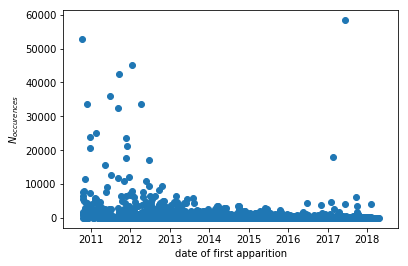

In [236]:
plt.figure()
plt.scatter([n[1] for n in N_fdate],[n[0] for n in N_fdate])
plt.xlabel('date of first apparition')
#plt.ylim(0,10000)
plt.ylabel(r'$N_{occurences}$')
plt.savefig('N_data_first_apparition.pdf')
plt.show()

In [233]:
Outliers=[]
# Who are the outliers of the two last years (The places with a number of posts too high)
# But not extremely high.
dict_coord_name= dict(zip(df_new.coords,df_new.location_id))
dict_name_coord= dict(zip(df_new.location_id,df_new.coords))
print 'Extreme outliers: \n'
for n in N_fdate:
    if n[0]>20000:
        print dict_id_name[n[2]], '&', n[0], '\\\\'
        
print '\nOutliers from the last years:'
for n in N_fdate:
    if n[1].year>=2016:
        if n[0]>=2000 and n[0]<10000:
            Outliers.append((n[2],n[0]))
            print dict_id_name[n[2]],'&', n[0], '\\\\'
    if n[1].year>=2017:
        if n[0]>=1500 and n [0]<2000:
            Outliers.append((n[2],n[0]))
            print dict_id_name[n[2]],'&', n[0], '\\\\'
Outliers=[(e[0], e[1], dict_id_coord[e[0]]) for e in Outliers]

Extreme outliers: 

Mole Antonelliana & 36016 \\
Lingotto Fiere - Torino & 21362 \\
Parco del Valentino & 33533 \\
Monte dei Cappuccini, Turin & 23452 \\
Torino Centro & 58361 \\
Torino Porta Nuova & 20742 \\
Piazza San Carlo & 32457 \\
Pala Alpitour & 42589 \\
Piazza Castello & 52846 \\
Allianz Stadium & 45010 \\
Piazza Vittorio Veneto & 33771 \\
Venaria Reale & 25080 \\
Museo Egizio, Torino & 24014 \\

Outliers from the last years:
Piano35 lounge bar & 4464 \\
MILK Torino & 3515 \\
GAM Torino & 4120 \\
EDIT - Torino & 1658 \\
Palazzo Madama, Turin & 4584 \\
Museo Nazionale del Cinema di Torino & 6163 \\
Museo Nazionale dell'Automobile & 1713 \\
Torino Outlet Village & 2563 \\
Juventus Stadium & 4065 \\
Parco della Pellerina & 3943 \\


In [149]:
Places_to_get=[]
# How to access the points which are out of the general tendency (monuments, etc. ?)
for k in dict_places_n.keys():
    if dict_places_n[k]>10000:
        Places_to_get.append([dict_name_coord[k],dict_places_n[k]])

#Places_to_get is a list of [(lat,lon), N_post] for the places with a unusually high N_post.

In [ ]:
# Where are the places that gather so much posts, on a map?
m = folium.Map(location=[np.mean([c[0][0] for c in Places_to_get]),np.mean([c[0][1] for c in Places_to_get])], zoom_start=12)
for p in Places_to_get:
    folium.Marker(p[0]).add_to(m)
m
#m.save('places_hiN.html')

#And what are their time series?
IL.plot_time_series(Places_to_get,dict_coord_name,df_new,'filename',False)

In [ ]:
df_new_index,df_new_nodup2=IL.indexed_dataframe(df_new,step_lon,step_lat,number_lats)

In [155]:
print len(set(df_new.coords.tolist())), 'different coords in the dataset'
print len(set(df_new.coordsbin.tolist())), 'different bins in the dataset'

5818 different coords in the dataset
518 different bins in the dataset


In [156]:
#Make an index of only the years + months and text of posts
df_new_index=df_new[['date','text','coordsbin']]
df_new_index['date'] = pd.to_datetime(df_new_index['date'], errors='coerce')
df_new_index['year_month'] = list(zip(df_new_index['date'].dt.year, df_new_index['date'].dt.month)) #add a month column
yearmin=min([y[0] for y in df_new_index.year_month.tolist()])
df_new_index['month_abs']=[(e[0]-yearmin)*12+e[1] for e in df_new_index.year_month]

/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [162]:
print df_new_index.shape
print len(df_new_index.text.tolist()), 'posts in df_new_index'
print 'among which',len(set(df_new_index.text.tolist())), 'are unique'

(2037329, 5)
2037329 posts in df_new_index
among which 1874444 are unique


'### Checkpoint 4

In [164]:
#And pickle it
#df_new_index.to_pickle('df_new_index_chkpt4.pkl')
#df_new_index=pd.read_pickle('df_new_index_chkpt4.pkl')


In [165]:
list_years=list(set([e[0] for e in df_new_index.year_month.tolist()]))
list_months=list(set([e[1] for e in df_new_index.year_month.tolist()]))
print sorted(list_years)
print sorted(list_months)

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [166]:
start=datetime(2010,10,1)
stop=datetime(2018,12,12)
flags=IL.TimeFlags(start,stop,'months',1)
slices=[(f,f+relativedelta(months=1)) for f in flags]

In [167]:
df_classified=IL.dataframe_classified(slices,df_new_index)
df_classified.head()

2010-10-01 2010-11-01 20


Instalib.py:542: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_sliced['text'] = df_sliced.groupby('coordsbin')['text'].transform(lambda x: ','.join(x))


2010-11-01 2010-12-01 39
2010-12-01 2011-01-01 50
2011-01-01 2011-02-01 47
2011-02-01 2011-03-01 124
2011-03-01 2011-04-01 165
2011-04-01 2011-05-01 148
2011-05-01 2011-06-01 173
2011-06-01 2011-07-01 122
2011-07-01 2011-08-01 142
2011-08-01 2011-09-01 68
2011-09-01 2011-10-01 138
2011-10-01 2011-11-01 177
2011-11-01 2011-12-01 206
2011-12-01 2012-01-01 258
2012-01-01 2012-02-01 269
2012-02-01 2012-03-01 289
2012-03-01 2012-04-01 397
2012-04-01 2012-05-01 574
2012-05-01 2012-06-01 918
2012-06-01 2012-07-01 988
2012-07-01 2012-08-01 871
2012-08-01 2012-09-01 670
2012-09-01 2012-10-01 1393
2012-10-01 2012-11-01 1771
2012-11-01 2012-12-01 1772
2012-12-01 2013-01-01 1846
2013-01-01 2013-02-01 1279
2013-02-01 2013-03-01 1467
2013-03-01 2013-04-01 1892
2013-04-01 2013-05-01 2219
2013-05-01 2013-06-01 2591
2013-06-01 2013-07-01 2740
2013-07-01 2013-08-01 2287
2013-08-01 2013-09-01 1707
2013-09-01 2013-10-01 2541
2013-10-01 2013-11-01 2700
2013-11-01 2013-12-01 3193
2013-12-01 2014-01-01 2613


,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,result
coordsbin,,,,,,,,,,,,,,,,,,,,,
"(45.0045, 7.60194240037)",,,,,,,,,,,...,Quando ho scritto questo brano sognavo di camb...,Punti riflessi sulla mano \nreflessologia rifl...,PORTA UN AMICOA e Noi ti Regaliamo un Trattame...,,,,,,,AppuntamentoFisso☀️💁🏻 Secondo step 💅🏻\nEpilazi...
"(45.0045, 7.62105876852)",,,,,,,,,,,...,"❤💣❤💣,Today 🍬\n\nminions candy carrefour minion...","Finish,Laùra barbù FeG menatwork carrefour tor...",Montaggio sedute Catifa di official per il nu...,Semplicemente leggero 🍣 🇮🇹 ❤️ instagood instag...,Love ❤ guscio gusciostore gusciostoreiviali iv...,nucleokids newcollection pe nucleo baby babybo...,"\nyngychy \nT shirt € 🏀😎👊🏼👊🏼👊🏼,Viaspettiamo💎...",🌸Correndo 🏃🏽‍♀️💨Pausa spuntino a lavoro ✔️ 👉🏻...,,"❤☀💎\nmamma,secondaparte tegocalderon reaggaeto..."
"(45.0045, 7.64654725938)",,,,,,,,,,,...,,,Thank you all º Royal Cup Torino Turin champio...,,,,,,,Ci abbiamo provato almeno✌🏻️ Grandi ragazze se...
"(45.0045, 7.6529193821)",,,,,,,,,,,...,SAMMOSSCH escaperoom SAW la quarta stanza vi...,Halloween👻👹 I LOSERS😜nella nostra area selfi...,GLI SCOPPIATI SAW la quarta stanza è aperta 🗝...,Enigmaticamente augura a TUTTI VOI un feliciss...,I LEONI 🗝🔓escaperoom Lipnotista minuti⏰ e tant...,ATLETICO GAUDENZIO escaperoom SAW🗝🔒 Avete cred...,LE PATONE nellIPNOTISTA\nLa mente è il luogo ...,I VENERDÌ escaperoom SAW🗝🔒 Avete creduto che...,,Buon Aliiiiii ❤️🍹happybday happybirthday buon...
"(45.0045, 7.65929150481)",,,,,,,,,,,...,,,Cucciolo di Monviso,Per noi fare memoria significa prima di tutto ...,Memoria\n\nPrima di partire per auschwitz gli ...,Hai mai sognato di scrivere cantare e registra...,,,,Quando i colleghi ti viziano non è necessario ...


### Checkpoint 5

In [238]:
#And pickle it
#df_new.to_pickle('df_new_chkpt5.pkl')
#df_new_index.to_pickle('df_new_index_chkpt5.pkl')
#df_classified.to_pickle('df_classified_chkpt5.pkl')

#df_new=pd.read_pickle('df_new_chkpt5.pkl')
#df_new_index=pd.read_pickle('df_new_index_chkpt5.pkl')
#df_classified=pd.read_pickle('df_classified_chkpt5.pkl')


In [245]:
if 1:
    lat1,lat2,step_lat,lon1,lon2,step_lon,to_bin_lon,to_bin_lat = IL.build_grid(df_new,step_m)
    number_lats,number_lon,df_new=IL.add_grid_todf(df_new,to_bin_lat,to_bin_lon,step_lat,step_lon)
    print (number_lats, number_lon)
    #Make an index of only the years + months and text of posts
    gc.collect()
    list_date=list(set([e.date() for e in df_new.date.tolist()]))
    list_years=list(set([e.year for e in list_date]))
    list_months=list(set([e.month for e in list_date]))
    df_new_index=df_new[['date','text','coordsbin']]
    df_new_index['date'] = pd.to_datetime(df_new_index['date'], errors='coerce')
    df_new_index['year_month'] = list(zip(df_new_index['date'].dt.year, df_new_index['date'].dt.month)) #add a month column
    yearmin=min([y[0] for y in df_new_index.year_month.tolist()])
    df_new_index['month_abs']=[(e[0]-yearmin)*12+e[1] for e in df_new_index.year_month]

(31.00000000000114, 31.000000000000007)


/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [243]:
# Let's group the data by month and count how many coordsbin we have. 

# Group by month:
count_Ncells_time=df_new_index[['month_abs','coordsbin']].set_index('coordsbin').groupby('month_abs')
# Access the dictionary of groups (groups are the keys, coords are the values):
dict_month_Ncells=count_Ncells_time.groups
# For each month, let's count how many cells are filled.
list_coords_Nposts=[]
for month in dict_month_Ncells.keys():
    coords=dict_month_Ncells[month]
    # We want to keep only one occurence for each cell grid.
    list_coords_Nposts.append((month, len(set(coords))))


In [249]:
dates_Ncells=[IL.abs_to_yearmonth(m[0],list_years) for m in list_coords_Nposts]

In [ ]:
for gridstep in [.5,1,3,5]:
    plt.figure()
    dates_Ncells_1, list_coords_Nposts_1 = IL.N_cells_info(df_new,gridstep)
    plt.plot(dates_Ncells_1,[e[1] for e in list_coords_Nposts_1])
    plt.xlabel('Month')
    plt.ylabel(r'$N_{cells}$ filled')
    plt.savefig('N_gridcells_step='+str(gridstep)+'.pdf')
    plt.show()
    
    steplon=gridstep/(40000*math.cos((lat1+lat2)*math.pi/360)/360)
    steplat=gridstep/(40000./360.)

for gridstep in [.5,1,3,5]:
    lng=lon1
    lonbins=[lng]
    while lng<lon2+steplon:
        lng+=steplon
        lonbins.append(lng)

    lat=lat1
    latbins=[lat]
    while lat<lat2+steplat:
        lat+=steplat
        latbins.append(lat)
    continue
        # Link the locations associated to a place in particular to visualise what it means.
    m = folium.Map(location=[np.mean(latbins),np.mean(lonbins)], zoom_start=12)
    for lng in lonbins:
        folium.PolyLine(locations=((min(latbins),lng),(max(latbins),lng)),weight=1).add_to(m)
    for lat in latbins:
        folium.PolyLine(locations=((lat,min(lonbins)),(lat,max(lonbins))),weight=1).add_to(m)
    #m.save('grid_'+str(gridstep)+'.html') 

# Term vector building by NTF

Stemming = removing all suffixes in the word to keep only its root.

This part executes NMF on time slices of the data, to have an idea of what the output might be. It generates .mat files that can be used by matlab.

More about NMF here: https://scikit-learn.org/stable/modules/decomposition.html#nmf

In [519]:
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
import nltk.data #
nltk.download('punkt')
from nltk.stem.snowball import FrenchStemmer
#Filter out the monuments?
monuments=False
if monuments:
    all_stopwords=IL.all_stopwords.union(IL.words_monuments)
else:
    all_stopwords=IL.all_stopwords

italian_stemmer = nltk.stem.SnowballStemmer('italian')
list_reviews_all=df_classified.result.tolist()
n_features=1000

class StemmedCountVectorizer(CountVectorizer):
    # This class is basically a CountVectorizer class that has been enhanced with a stemmer method.
    def build_analyzer(self):
        #Use super to access the method build_analyzer form the class CountVectorizer.
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])

#Build the vectorizer and the list of all words in the dataset
#df_new=pd.read_pickle('Tor_instagram_2.pkl')
vectorizer_s = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=all_stopwords)     
while '' in list_reviews_all:
    list_reviews_all.remove('')
while "" in list_reviews_all:
    list_reviews_all.remove("")

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


More info about countvectorizer here: 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

And about TfIdf: 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

And about NMF:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [ ]:
#pickle.dump(df_classified, open('df_granularity.pkl','wb'))

In [521]:
#counts = vectorizer_s.fit_transform(list_reviews_all)
#pickle.dump(counts, open('counts_master.pkl','wb'))
#pickle.dump(vectorizer_s, open('vec_s_master.pkl','wb'))
#counts = pickle.load( open( 'counts_master.pkl', "rb" ) )
vectorizer_s = pickle.load( open( 'vec_s_master.pkl', "rb" ) )

In [522]:
reload(IL)
vectorizer_new = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=all_stopwords,vocabulary=vectorizer_s.vocabulary_) 
voc_vector={k:v for v,k in vectorizer_s.vocabulary_.iteritems()}
voc_serie=pd.Series(voc_vector)
#F = open('termvectors_sampling_5topics.txt','a') 
start=80
stop=90
n_topics=10
sampling=True
for sample_run in xrange(1):
    A,B,C,TermVectorsIndex,TermVectors = IL.NTF_sampling(sampling,df_classified,flags,start,stop,vectorizer_new=vectorizer_new,vectorizer_s=vectorizer_s,n_topics=n_topics,n_features=n_features)       
    for tvi in TermVectorsIndex:
        print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:8]]
#        F.write(str([t[0] for t in tvi[0:10]]))
#        F.write('\n')
#F.close()

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/eartiges/miniconda3/envs/jupyG/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lamiacitt', 'torino\xc3'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


The threshold is 68856
2017-06-01 00:00:00
68856


KeyboardInterrupt: 

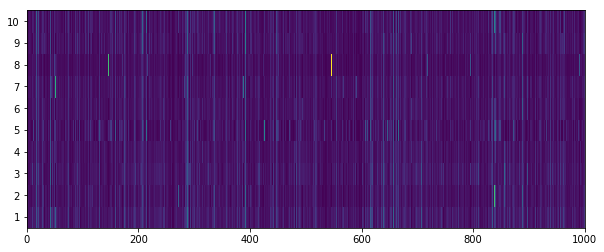

In [500]:
#Topics definition
plt.figure(figsize=(10,4))
plt.pcolormesh(B.T)#, cmap=plt.cm.Greys)
plt.xlim(0,B.shape[0])
plt.yticks(np.arange(B.shape[1])+0.5, np.arange(1,B.shape[1]+1))
#plt.savefig('Topic_definition_normalized.pdf')
plt.show()

#for tvi in TermVectorsIndex:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
#    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:5]]

In [ ]:
CommonWords=set([])
for t in TermVectors:
    for t_other in TermVectors:
        if t_other!=t:
            for term in t.union(t_other):
                CommonWords.add(term)

In [ ]:
for t in TermVectors:
    T=list(t)
    print len(t)
    for word in t:
        if word in CommonWords:
            T.remove(word)
    t=set(T)
    print len(T)

In [502]:
for tvi in TermVectorsIndex:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0].encode('utf-8') for t in tvi[0:5]]

0 ['fashion', 'sempr', 'art', 'photography', 'music']
1 ['summer', 'happy', 'torino\xc3\xa8lamiacitt', 'estat', 'relax']
2 ['photography', 'tatto', 'sempr', 'music', 'art']
3 ['fashion', 'photography', 'art', 'natur', 'sempr']
4 ['night', 'iphones', 'sky', 'happy', 'day']
5 ['torino\xc3\xa8lamiacitt', 'music', 'fashion', 'sempr', 'happy']
6 ['autumn', 'halloween', 'autunn', 'fashion', 'happy']
7 ['natal', 'christmas', 'winter', 'buon', 'xmas']
8 ['happy', 'smil', 'fashion', 'torino\xc3\xa8lamiacitt', 'amazing']
9 ['summer', 'happy', 'smil', 'self', 'amazing']


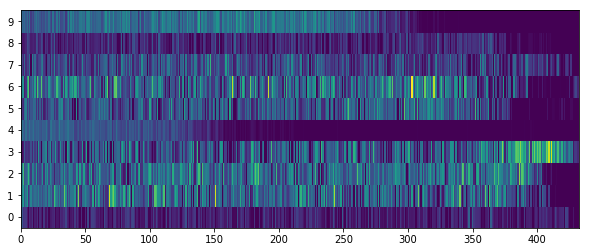

9 [u'summer', u'happy', u'smil', u'self', u'amazing']
8 [u'happy', u'smil', u'fashion', u'torino\xe8lamiacitt', u'amazing']
7 [u'natal', u'christmas', u'winter', u'buon', u'xmas']
6 [u'autumn', u'halloween', u'autunn', u'fashion', u'happy']
5 [u'torino\xe8lamiacitt', u'music', u'fashion', u'sempr', u'happy']
4 [u'night', u'iphones', u'sky', u'happy', u'day']
3 [u'fashion', u'photography', u'art', u'natur', u'sempr']
2 [u'photography', u'tatto', u'sempr', u'music', u'art']
1 [u'summer', u'happy', u'torino\xe8lamiacitt', u'estat', u'relax']
0 [u'fashion', u'sempr', u'art', u'photography', u'music']


In [503]:
#Topics by bin
plt.figure(figsize=(10,4))
plt.pcolormesh(A.T)#, cmap=plt.cm.Greys)
plt.xlim(0,A.shape[0])
plt.yticks(np.arange(B.shape[1])+0.5, np.arange(0,B.shape[1]+1))
#plt.savefig('Topic_bybin_normalized.pdf')
plt.show()

for tvi in TermVectorsIndex[::-1]:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:5]]

In [421]:
for index in range(0,len(A.T)):
    row=A.T[index]
    print 'topic',index, '[',min(row),';', max(row)*100,']'

topic 0 [ 0.0 ; 0.24316938931778767 ]
topic 1 [ 0.0 ; 0.3912705823290982 ]
topic 2 [ 0.0 ; 0.1434327029009428 ]
topic 3 [ 0.0 ; 0.30275403149775093 ]
topic 4 [ 0.0 ; 0.1283863275871082 ]
topic 5 [ 0.0 ; 0.16172198737061755 ]
topic 6 [ 0.0 ; 0.1322671196470942 ]
topic 7 [ 0.0 ; 0.06393980969112881 ]
topic 8 [ 0.0 ; 0.312362598375197 ]
topic 9 [ 0.0 ; 0.4056077966167093 ]
topic 10 [ 0.0 ; 0.3663982497865567 ]
topic 11 [ 0.0 ; 0.32173487511932697 ]
topic 12 [ 0.0 ; 0.16466448147615748 ]
topic 13 [ 0.0 ; 0.24637199856545042 ]
topic 14 [ 0.0 ; 0.34556820124451876 ]


In [504]:
reload(IL)
#Geographical repartition of topics
for index in range(0,len(A.T)):
    Coordinates=list(df_classified.index)
    row=A.T[index]
    topic=''
    for i in (1,2,3):
        topic+='_'+TermVectorsIndex[index][i][0]
    IL.geo_topic(row,Coordinates,index,topic=topic,save=True,folder='Heatmaps_1701NTF')

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Heatmaps_1701NTF created


In [352]:
for tvi in TermVectorsIndex[::-1]:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:5]]

14 [u'mol', u'night', u'buongiorn', u'immagin', u'murazz']
13 [u'iphones', u'paratissim', u'streetphotography', u'ros', u'light']
12 [u'iphon', u'iphones', u'photography', u'cool', u'th']
11 [u'iphon', u'photography', u'phot', u'night', u'iphones']
10 [u'plac', u'fot', u'phot', u'day', u'drawing']
9 [u'color', u'sky', u'night', u'ciel', u'po']
8 [u'iphones', u'streetphotography', u'paratissim', u'snow', u'iphon']
7 [u'rain', u'buon', u'brav', u'port', u'amic']
6 [u'iphones', u'piazz', u'bell', u'sky', u'street']
5 [u'iphon', u'night', u'animal', u'churc', u'yellow']
4 [u'sush', u'dolc', u'cas', u'ris', u'old']
3 [u'san', u'streetphotography', u'luc', u'light', u'sunris']
2 [u'sky', u'winter', u'ciel', u'cas', u'sunset']
1 [u'sott', u'adess', u'mett', u'far', u'andar']
0 [u'snow', u'nev', u'tre', u'winter', u'rom']


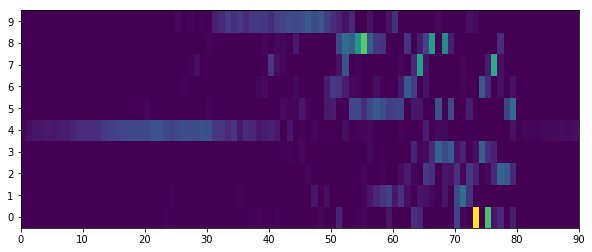

9 [u'summer', u'happy', u'smil', u'self', u'amazing']
8 [u'happy', u'smil', u'fashion', u'torino\xe8lamiacitt', u'amazing']
7 [u'natal', u'christmas', u'winter', u'buon', u'xmas']
6 [u'autumn', u'halloween', u'autunn', u'fashion', u'happy']
5 [u'torino\xe8lamiacitt', u'music', u'fashion', u'sempr', u'happy']
4 [u'night', u'iphones', u'sky', u'happy', u'day']
3 [u'fashion', u'photography', u'art', u'natur', u'sempr']
2 [u'photography', u'tatto', u'sempr', u'music', u'art']
1 [u'summer', u'happy', u'torino\xe8lamiacitt', u'estat', u'relax']
0 [u'fashion', u'sempr', u'art', u'photography', u'music']


In [505]:
#Topics Dynamics
plt.figure(figsize=(10,4))
plt.pcolormesh([c for c in C.T])#, cmap=plt.cm.Greys)
#plt.xlim(0,len(C.T[0])-start)
#plt.savefig('Topic_dynamic.pdf')
plt.yticks(np.arange(n_topics)+0.5, np.arange(0,n_topics));
#plt.xticks(flags[start:stop])
plt.show()
for tvi in TermVectorsIndex[::-1]:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:5]]

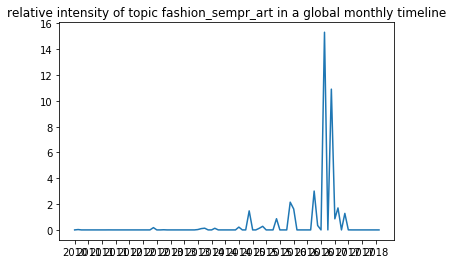

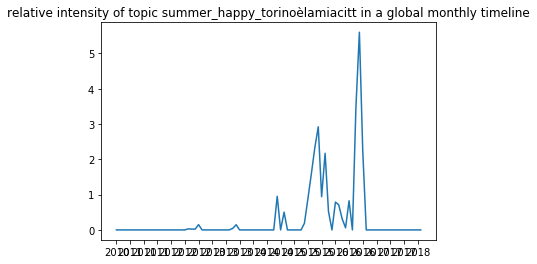

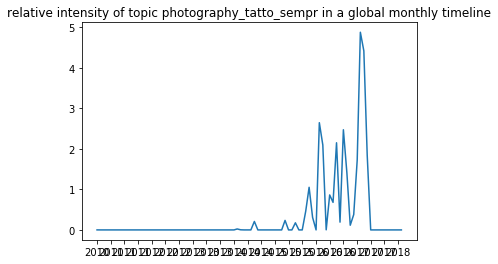

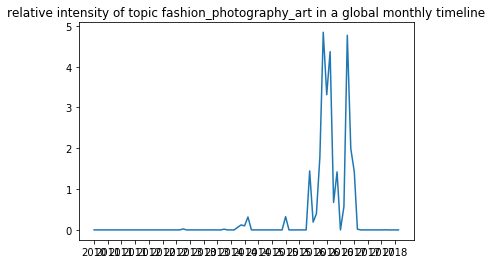

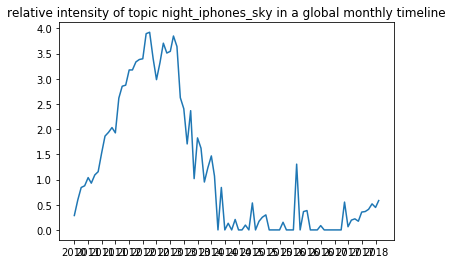

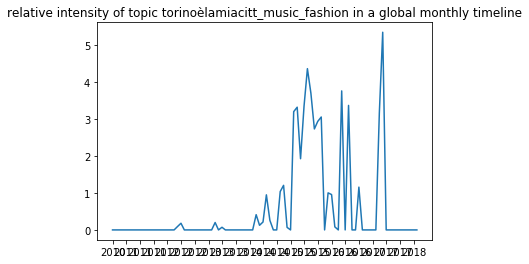

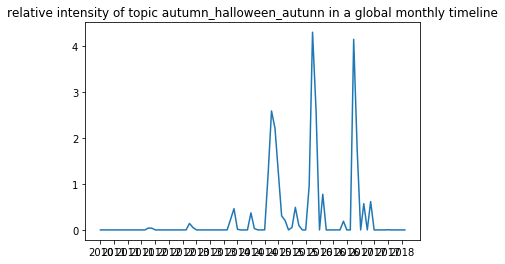

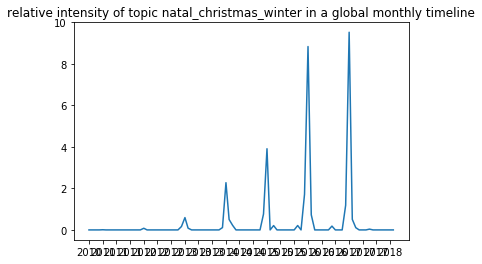

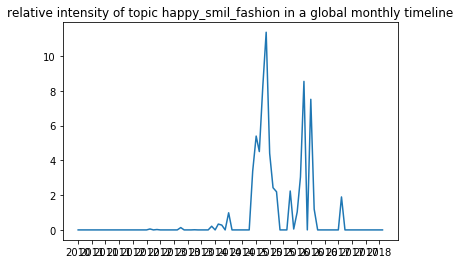

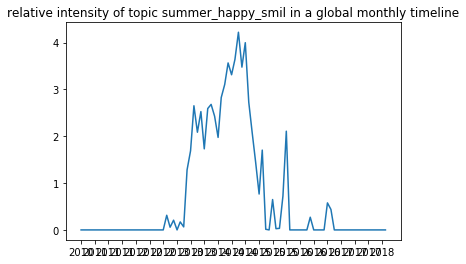

In [507]:
for index in range(0, len(C.T)):
    row=C.T[index]
    topic=''
    for i in (0,1,2):
        topic+=TermVectorsIndex[index][i][0]+'_'
    topic=topic.strip('_')
    plt.figure()
    plt.plot(flags[start:stop], row)
    plt.xticks(flags[start:stop][::4])
    plt.title('relative intensity of topic '+topic+' in a global monthly timeline')
    if True:
        if 'sample_timelines' not in os.listdir('.'):
            os.mkdir('sample_timelines')
        plt.savefig('sample_timelines/plot_topic'+topic+'.pdf')
    plt.show()

In [ ]:
dfa = pd.DataFrame(A).groupby(voc_serie).sum()
#dfa = dfa[dfa.index!='teachers']

In [ ]:
dfa

In [ ]:
plt.figure(figsize=(10,4))
plt.pcolormesh(C.T)#, cmap=plt.cm.Greys)
plt.xlim(0,C.shape[0])
plt.yticks(np.arange(14)+0.5, np.arange(1,15));

In [ ]:
import scipy.io
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.io import savemat
n_features=1000
n_topics=10

list_reviews_all=df_new['text'].tolist()
counts = vectorizer_s.fit_transform(list_reviews_all)
vectorizer_new = CountVectorizer(max_df=0.95, max_features=n_features,stop_words=all_stopwords_add,vocabulary=vectorizer_s.vocabulary_)
ct=0

# For each month in the dataset, get a snapshot view of the NMF tensor:
for month in range(1,(len(list_years)-1)*12+2,3):
    
    year_start=list_years[0]+ int(month/12)
    month_start=month%12  
    year_end=list_years[0]+ int(month+11-0.5)/12
    month_end=1+(month+11-1)%12
    
    try:
        list_reviews_rest=dataframe_collection[str(year_start) + '-' + str(month_start)]['text'].tolist()
    except KeyError:
        continue
        
    # Learn the vocabulary dictionary and return term-document matrix.
    counts = vectorizer_new.fit_transform(list_reviews_rest)
    
    #Transform a count matrix to a normalized tf-idf representation. 
    #(mainly =Terms with frequencies too hi or lo are removed)
    tfidf = TfidfTransformer().fit_transform(counts)
    
    #Save the data in matlab friendly format
    savemat('Inst500Matr' + str(ct), {'tfidf':tfidf})
    
    
    nmf = decomposition.NMF(n_components=n_topics)
    
    #We are looking for two matrices whose product approximates tfidf.
    
    # Learn the model (parameters etc.). I.e "take a look at what we have". returns nothing.
    W = nmf.fit(tfidf)
    
    # dictionary (factorization matrix)
    H = nmf.components_
    
    # Extracts the data and performs NMF on the tfidf-treated dataset. 
    # Returns the matrix W (the weight matrix), to be multiplied by the matrix H (dictionary) to get target tfidf.
    X2 = nmf.fit_transform(tfidf)
    ct=ct+1
    feature_names = vectorizer_new.get_feature_names()
    print month
    for i,text_topic in enumerate(X2.T):
        
        # i.e -> i, [content of column i of X2]
        # i-th topic named text_topic
        # Why sort them backwards?
        text_top = text_topic.argsort()[:-21:-1]
        word_top = nmf.components_[i].argsort()[:-11:-1]
        
        # For each text topic in the NMF resulting list, print the weight vector and the term vector.
        print [nmf.components_[i,k] for k in nmf.components_[i].argsort()[:-11:-1]]
        print [", ".join([feature_names[i] for i in word_top])]
        
        # print the amount of non-zero components in the weight vector
        l=[text_topic[i] for i in text_top]
        print np.count_nonzero(l)
            

In [ ]:
>>> import numpy as np
>>> X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
>>> from sklearn.decomposition import NMF
>>> model = NMF(n_components=2, init='random', random_state=0)
>>> W = model.fit_transform(X)
>>> H = model.components_

In [ ]:
X

In [ ]:
for i, t in enumerate(X):
    print i,t

In [ ]:
print feature_names

In [ ]:
#save the feature names in a csv file
type(feature_names)
import io

f = io.open('test_inst_Torino.csv', 'w', encoding='utf8')
for item in feature_names:
    print item
    f.write("%s\n" % item)

In [ ]:
#Boundaries of the map
print (df_new['lonbin'].min()-step_lon/2., df_new['latbin'].min()-step_lat/2., df_new['lonbin'].max()+step_lon/2., df_new['latbin'].max()+step_lat/2)

In [ ]:
len(df_new_nodup_cells['n'].unique())
list_rc=df_new_nodup2_cells['n'].tolist()
with open('n_inst500.txt', 'w') as fp:
    fp.write('\n'.join('%s' % x for x in list_rc))

In [ ]:
list_rc

In [ ]:
df_new_nodup2_cells

In [ ]:
df_new_nodup2_cells.head()

In [ ]:
import time
import datetime
list_time=[]
for month in range(1,(len(list_years)-1)*12+2,3):
        year_start=list_years[0]+ int(month/12)
        month_start=month%12  
        year_end=list_years[0]+ int(month+11-0.5)/12
        month_end=1+(month+5-1)%12
             
     
        if month_end in([2,4,6,9,11]):
            day=30
        else:
            day=31
        deb=str(year_start) + '-' + str(month_end) + '-1'
        deb_new=time.mktime(datetime.datetime.strptime(deb, "%Y-%m-%d").timetuple())
        if month==1:
            list_time= np.append(deb_new,list_time)
        else:
            list_time=np.append(list_time,deb_new)


In [ ]:
print list_time

In [ ]:

with open('times_inst500.txt', 'w') as fp:
    fp.write('\n'.join('%s' % x for x in list_time))